<a href="https://colab.research.google.com/github/MatheusHenriqueDaSilva/data_science/blob/main/heart_disease_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição da probabilidade de doença cardíaca em pacientes.

Etapas:
1.   Data prep
2.   treinamento (Cross Validation na base de treino) e otimização de hiperparâmetros
3.   Avaliação do Light GBM


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
# Data understanding
DATA = pd.read_csv('/content/Heart_Disease_Prediction.csv')
DATA.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [3]:
DATA.shape

(270, 14)

In [4]:
def generate_metadata(dataframe):

    metadata2 = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata2=metadata2.sort_values(by='tipo')
    metadata2 = metadata2.reset_index(drop=True)

    return metadata2

metadados = generate_metadata(DATA)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Age,int64,0,0.0,41
1,Sex,int64,0,0.0,2
2,Chest pain type,int64,0,0.0,4
3,BP,int64,0,0.0,47
4,Cholesterol,int64,0,0.0,144
5,FBS over 120,int64,0,0.0,2
6,EKG results,int64,0,0.0,3
7,Max HR,int64,0,0.0,90
8,Exercise angina,int64,0,0.0,2
9,Slope of ST,int64,0,0.0,3


In [43]:
# Realizando HOLD-OUT da base, buscando conseguir avaliar o modelo posteriormente.
lista_spec = ['Heart Disease']
target = DATA['Heart Disease']
data_var = DATA.drop(lista_spec,axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(data_var,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


((189, 13), (81, 13), (189,), (81,))

### Tratando o TARGET do treino com label encolding e aplicando no teste

In [38]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
Y_train_label_enc= encoder.fit_transform(Y_train)
Y_train_label_enc

with open('/content/label_enc.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [39]:
# Carregar os encoders e a lista de colunas
with open('/content/label_enc.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

Y_test_label_enc = loaded_encoder.transform(Y_test)
Y_test_label_enc

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

### Padronizando a base de treino e aplicando no teste

In [41]:
from sklearn.preprocessing import StandardScaler
# Instanciando o scaler
scaler = StandardScaler()

# Padronizando a base de treino
X_train_scaled = scaler.fit_transform(X_train)
X_train_pad = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Salva o scaler em um arquivo .pkl
with open('/content/scaler_pad.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [44]:
# Carregar o scaler
with open('/content/scaler_pad.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Suponha test_df como sua base de teste
X_test_scaled = loaded_scaler.transform(X_test)
X_test_pad = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_pad.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
30,0.246885,0.665393,-0.219608,-0.212767,-0.429816,-0.399386,0.961082,0.029914,-0.766965,-0.633568,0.638691,0.312696,1.140517
116,-0.960818,0.665393,0.818039,-0.659578,-0.048251,-0.399386,0.961082,-0.233050,-0.766965,-0.298150,-0.992560,-0.724139,1.140517
79,0.137094,0.665393,-1.257255,-0.659578,-0.296268,-0.399386,-1.046039,1.257078,-0.766965,-0.298150,-0.992560,-0.724139,-0.917313
127,-0.302071,-1.502871,-0.219608,0.234044,-1.059399,-0.399386,0.961082,0.862632,-0.766965,-0.885132,0.638691,-0.724139,-0.917313
196,0.356676,-1.502871,0.818039,-1.776604,-0.067329,-0.399386,0.961082,-1.197250,-0.766965,-0.130441,0.638691,-0.724139,-0.917313


### feature selection

In [85]:
# FEATURE SELECTION
from sklearn.ensemble import RandomForestClassifier

X = X_train_pad
y = Y_train_label_enc

clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff = 0.01

#cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = features['Feature'][features['Importance'] > cutoff].tolist()

X_train_pad_feat = X_train_pad.loc[:,selected_features]

X_train_pad_feat.shape

(189, 12)

In [86]:
# Salvar a lista em um arquivo .pkl
import pickle
with open('/content/features_selec.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [87]:
# Carregar a lista do arquivo .pkl
with open('/content/features_selec.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

X_test_pad_feat = X_test_pad[loaded_lista]

X_test_pad_feat.head()

,ST depression,Thallium,Chest pain type,Max HR,Age,Number of vessels fluro,BP,Slope of ST,Cholesterol,Exercise angina,Sex,EKG results
30,-0.633568,1.140517,-0.219608,0.029914,0.246885,0.312696,-0.212767,0.638691,-0.429816,-0.766965,0.665393,0.961082
116,-0.298150,1.140517,0.818039,-0.233050,-0.960818,-0.724139,-0.659578,-0.992560,-0.048251,-0.766965,0.665393,0.961082
79,-0.298150,-0.917313,-1.257255,1.257078,0.137094,-0.724139,-0.659578,-0.992560,-0.296268,-0.766965,0.665393,-1.046039
127,-0.885132,-0.917313,-0.219608,0.862632,-0.302071,-0.724139,0.234044,0.638691,-1.059399,-0.766965,-1.502871,0.961082
196,-0.130441,-0.917313,0.818039,-1.197250,0.356676,-0.724139,-1.776604,0.638691,-0.067329,-0.766965,-1.502871,0.961082


## Criando modelo

In [64]:
Y_train.value_counts()

Heart Disease
Absence     101
Presence     88
Name: count, dtype: int64

In [95]:
# criando o melhor preditor de light GBM
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

x_treino_final = X_train_pad_feat
y_treino_final = Y_train_label_enc
x_teste_final = X_test_pad_feat
y_teste_final = Y_test_label_enc

# Definindo o modelo
model = KNeighborsClassifier()

# Definindo os parâmetros para o grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 23],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5, # diminui o numero de folds por conta do baixo número de observações
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'roc_auc' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(x_treino_final, y_treino_final)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(x_teste_final)



best_model_knn = grid.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores Parâmetros:  {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}
Melhor AUC:  0.9115406162464985


In [96]:
with open('/content/best_model_knn.pkl', 'wb') as file:
  pickle.dump(best_model_knn, file)
best_model_knn


KNeighborsClassifier(metric='manhattan', n_neighbors=23)

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report


predict = best_model_knn.predict(x_teste_final)

print(confusion_matrix(y_teste_final, predict))
print(accuracy_score(y_teste_final, predict))
print(classification_report(y_teste_final, predict))

[[47  2]
 [10 22]]
0.8518518518518519
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        49
           1       0.92      0.69      0.79        32

    accuracy                           0.85        81
   macro avg       0.87      0.82      0.84        81
weighted avg       0.86      0.85      0.85        81



In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df


# Uso da função
metrics_df = calculate_metrics('lightGBM',best_model_knn, x_treino_final, y_treino_final, x_teste_final , y_teste_final )
metrics_df



,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,lightGBM,Treino,0.851852,0.857143,0.818182,0.922705,0.845410,0.719172
1,lightGBM,Teste,0.851852,0.916667,0.687500,0.904974,0.809949,0.677934


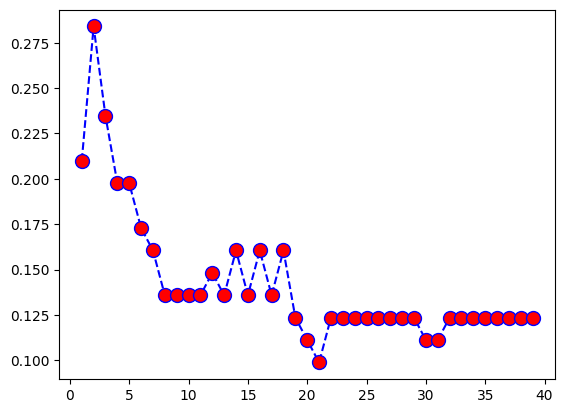

In [92]:
#verificando joelho
error_rate = []

# Levará algum tempo
for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_treino_final, y_treino_final)
    pred_i = knn.predict(x_teste_final)
    error_rate.append(np.mean(pred_i != y_teste_final))


plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.show()

CONCLUSÃO - O algoritmo KNN performou bem nessa análise, tendo bom resultado de gini e bom balanço vies/variança, conforme esperado.
observando joelho, poderíamos diminuir o tempo de processamento do modelo utilizando um K menor.